## Imports

In [41]:
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
from numba import njit
import time

##  Navier Stokes Equation

## Pure python

In [42]:
def build_up_b_pure(b, rho, dt, u, v, dx, dy):
    row, col = p.shape
        
        
    #fill the update of b
    
    for j in range(2, row):
        for i in range(2, col):
            b[j-1, i-1] = (rho * (1 / dt * 
                            ((u[j-1, i] - u[j-1, i-2]) / 
                             (2 * dx) + (v[j, i-1] - v[j-2, i-1]) / (2 * dy)) -
                            ((u[j-1, i] - u[j-1, i-2]) / (2 * dx))**2 -
                              2 * ((u[j, i-1] - u[j-2, i-1]) / (2 * dy) *
                                   (v[j-1, i] - v[j-1, i-2]) / (2 * dx))-
                                  ((v[j, i-1] - v[j-2, i-1]) / (2 * dy))**2))

    return b

def pressure_poisson_pure(p, dx, dy, b):
    pn = np.empty_like(p)
    pn = np.copy()
    
        
    for q in range(nit):
        pn = p.copy()
        row, col = p.shape
        
        
        for j in range(2, row):
            for i in range(2, col):
                p[j-1, i-1] = (((pn[j-1, i] + pn[j-1, i-2]) * dy**2 + 
                                  (pn[j, i-1] + pn[j-2, i-1]) * dx**2) /
                                  (2 * (dx**2 + dy**2)) -
                                  dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                                  b[j-1, i-1])

        p[:, -1] = p[:, -2] 
        p[0, :] = p[1, :]   
        p[:, 0] = p[:, 1]   
        p[-1, :] = 0        

        
    return p

def cavity_flow_pure(nt, u, v, dt, nx, ny, dx, dy, p, rho, nu):
    un = np.empty_like(u)
    vn = np.empty_like(v)
    b = np.zeros((ny, nx))
    
    pn = np.empty_like(p)
    pn = p.copy()
     
    for n in range(nt):
        un = u.copy()
        vn = v.copy()
        
        b = build_up_b_pure(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson_pure(p, dx, dy, b)
        row, col = p.shape
        
        
        for j in range(2, row):
            for i in range(2, col):
                u[j-1, i-1] = (un[j-1, i-1]-
                                 un[j-1, i-1] * dt / dx *
                                (un[j-1, i-1] - un[j-1, i-2]) -
                                 vn[j-1, i-1] * dt / dy *
                                (un[j-1, i-1] - un[j-2, i-1]) -
                                 dt / (2 * rho * dx) * (p[j-1, i] - p[j-1, i-2]) +
                                 nu * (dt / dx**2 *
                                (un[j-1, i] - 2 * un[j-1, i-1] + un[j-1, i-2]) +
                                 dt / dy**2 *
                                (un[j, i-1] - 2 * un[j-1, i-1] + un[j-2, i-1])))
        
                v[j-1, i-1] = (vn[j-1, i-1] -
                                un[j-1, i-1] * dt / dx *
                               (vn[j-1, i-1] - vn[j-1, i-2]) -
                                vn[j-1, i-1] * dt / dy *
                               (vn[j-1, i-1] - vn[j-2, i-1]) -
                                dt / (2 * rho * dy) * (p[j, i-1] - p[j-2, i-1]) +
                                nu * (dt / dx**2 *
                               (vn[j-1, i] - 2 * vn[j-1, i-1] + vn[j-1, i-2]) +
                                dt / dy**2 *
                               (vn[j, i-1] - 2 * vn[j-1, i-1] + vn[j-2, i-1])))

        u[0, :]  = 0
        u[:, 0]  = 0
        u[:, -1] = 0
        u[-1, :] = 1    
        v[0, :]  = 0
        v[-1, :] = 0
        v[:, 0]  = 0
        v[:, -1] = 0
        
        
        
        
    return u, v, p

## Numba accelerator

In [43]:
#@njit(fastmath=True)
def build_up_b_numba(b, rho, dt, u, v, dx, dy):
    row, col = p.shape
        
        
    #fill the update of b
    
    for j in range(2, row):
        for i in range(2, col):
            b[j-1, i-1] = (rho * (1 / dt * 
                            ((u[j-1, i] - u[j-1, i-2]) / 
                             (2 * dx) + (v[j, i-1] - v[j-2, i-1]) / (2 * dy)) -
                            ((u[j-1, i] - u[j-1, i-2]) / (2 * dx))**2 -
                              2 * ((u[j, i-1] - u[j-2, i-1]) / (2 * dy) *
                                   (v[j-1, i] - v[j-1, i-2]) / (2 * dx))-
                                  ((v[j, i-1] - v[j-2, i-1]) / (2 * dy))**2))


    return b
#@njit(fastmath=True)
def pressure_poisson_numba(p, dx, dy, b):
    pn = np.empty_like(p)
    pn = np.copy()
    #fill the update of p
    for q in range(nit):
        pn = p.copy()
        row, col = p.shape
        
        
        for j in range(2, row):
            for i in range(2, col):
                p[j-1, i-1] = (((pn[j-1, i] + pn[j-1, i-2]) * dy**2 + 
                                  (pn[j, i-1] + pn[j-2, i-1]) * dx**2) /
                                  (2 * (dx**2 + dy**2)) -
                                  dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                                  b[j-1, i-1])

        p[:, -1] = p[:, -2] 
        p[0, :] = p[1, :]   
        p[:, 0] = p[:, 1]  
        p[-1, :] = 0        
        
    return p
@njit(fastmath=True)
def cavity_flow_numba(nt, u, v, dt, nx, ny, dx, dy, p, rho, nu):
    un = np.empty_like(u)
    vn = np.empty_like(v)
    b = np.zeros((ny, nx))
    
    pn = np.empty_like(p)
    pn = p.copy()
    
    #fill the update of u and v
    for n in range(nt):
        un = u.copy()
        vn = v.copy()
        
        b = build_up_b_numba(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson_numba(p, dx, dy, b)
        row, col = p.shape
        
        
        for j in range(2, row):
            for i in range(2, col):
                u[j-1, i-1] = (un[j-1, i-1]-
                                 un[j-1, i-1] * dt / dx *
                                (un[j-1, i-1] - un[j-1, i-2]) -
                                 vn[j-1, i-1] * dt / dy *
                                (un[j-1, i-1] - un[j-2, i-1]) -
                                 dt / (2 * rho * dx) * (p[j-1, i] - p[j-1, i-2]) +
                                 nu * (dt / dx**2 *
                                (un[j-1, i] - 2 * un[j-1, i-1] + un[j-1, i-2]) +
                                 dt / dy**2 *
                                (un[j, i-1] - 2 * un[j-1, i-1] + un[j-2, i-1])))
        
                v[j-1, i-1] = (vn[j-1, i-1] -
                                un[j-1, i-1] * dt / dx *
                               (vn[j-1, i-1] - vn[j-1, i-2]) -
                                vn[j-1, i-1] * dt / dy *
                               (vn[j-1, i-1] - vn[j-2, i-1]) -
                                dt / (2 * rho * dy) * (p[j, i-1] - p[j-2, i-1]) +
                                nu * (dt / dx**2 *
                               (vn[j-1, i] - 2 * vn[j-1, i-1] + vn[j-1, i-2]) +
                                dt / dy**2 *
                               (vn[j, i-1] - 2 * vn[j-1, i-1] + vn[j-2, i-1])))

        u[0, :]  = 0
        u[:, 0]  = 0
        u[:, -1] = 0
        u[-1, :] = 1    # set velocity on cavity lid equal to 1
        v[0, :]  = 0
        v[-1, :] = 0
        v[:, 0]  = 0
        v[:, -1] = 0
        
        
        
        
    return u, v, p

## Inputs

<ipython-input-46-5e7d24abd12b>:26: UserWarning: No contour levels were found within the data range.
  pyplot.contour(X, Y, p, cmap=cm.viridis)


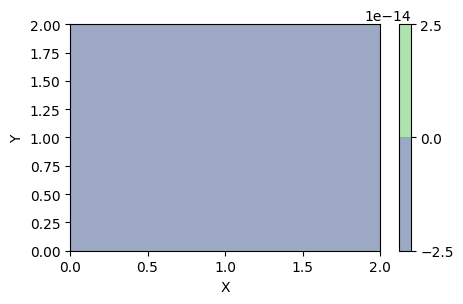

In [46]:
nx = 41
ny = 41
nt = 500
nit = 50
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)
X, Y = np.meshgrid(x, y)

rho = 1
nu = .1
dt = .001

u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx)) 
b = np.zeros((ny, nx))

u, v, p = cavity_flow_numba(nt, u, v, dt, nx, ny, dx, dy, p, rho, nu)

fig = pyplot.figure(figsize=(5, 3), dpi=100)
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, p, cmap=cm.viridis)
pyplot.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2])
pyplot.xlabel('X')
pyplot.ylabel('Y');

<ipython-input-27-2a44643bc2ca>:4: UserWarning: No contour levels were found within the data range.
  pyplot.contour(X, Y, p, cmap=cm.viridis)


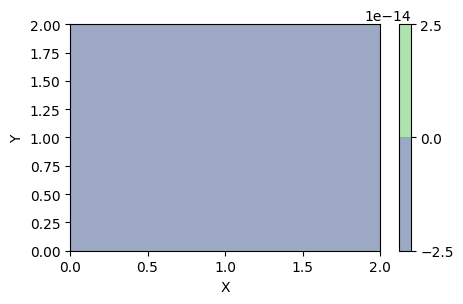

In [27]:
fig = pyplot.figure(figsize=(5, 3), dpi=100)
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, p, cmap=cm.viridis)
pyplot.streamplot(X, Y, u, v)
pyplot.xlabel('X')
pyplot.ylabel('Y');

## Call Funtions

## Pure python function

In [40]:
%timeit cavity_flow_pure(nt, u, v, dt, ny, ny, dx, dy, p, rho, nu)

TypeError: _copy_dispatcher() missing 1 required positional argument: 'a'

## Numba accelerator

In [36]:
%timeit cavity_flow_numba(nt, u, v, dt, ny, ny, dx, dy, p, rho, nu)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1mUntyped global name 'build_up_b_numba':[0m [1m[1mcannot determine Numba type of <class 'function'>[0m
[1m
File "<ipython-input-34-c5de8e0cd46c>", line 58:[0m
[1mdef cavity_flow_numba(nt, u, v, dt, nx, ny, dx, dy, p, rho, nu):
    <source elided>
        
[1m        b = build_up_b_numba(b, rho, dt, u, v, dx, dy)
[0m        [1m^[0m[0m
[0m

In [ ]:
vn = numpy.empty_like(v)